<h1>
<center>Cost Sensitive Learning</center>
</h1>

### Generals

In [1]:
import numpy as np
from sklearn.datasets import  fetch_openml
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt

<h2>
<center>Main Functionality</center>
</h2>

### Data Preprocessing

In [2]:
def get_preprocessed_data():
    x, y = fetch_openml("credit-g", version=1, as_frame=True, return_X_y=True)
    one_hot_encoder = make_column_transformer((OneHotEncoder(handle_unknown='ignore'),
                                     make_column_selector(dtype_include='category')),remainder='passthrough')

    x = one_hot_encoder.fit_transform(x)
    y = y.map({'good': 1, 'bad': 0})
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
    x_train,x_test = scaller(x_train,x_test)

    return x_train,y_train,x_test,y_test

In [3]:
def scaller(x_train,x_test):
    Standar_Scaller = StandardScaler()
    scalled_train_data= Standar_Scaller.fit_transform(x_train)
    scalled_test_data = Standar_Scaller.transform(x_test)
    return scalled_train_data,scalled_test_data

## Minimizing Expected Cost

<font size="3">
<h4>Aim:</h4>
<ul>
  <li>Apply cost-sensitive learning using the minimizing expected cost approach to three different machine learning models (Naive Bayes, Linear SVM, Random Forest).</li>
  <li>Compare the performance of each model with and without cost-sensitive learning.</li>
</ul>
<h4>Steps:</h4>
<ul>
  <li>Define a function that takes in a list of machine learning models, training and testing data, and a cost matrix.</li>
  <li>For each model, the function performs the following:
    <ul>
      <li>Trains the model on the training data without any cost minimization.</li>
      <li>Calculates the cost of the predictions made by the model on the testing data.</li>
      <li>Applies cost minimization using isotonic calibration and calculates the cost of the predictions made by the model on the testing data.</li>
      <li>Stores the model, the initial cost, and the cost after cost minimization in a dictionary and appends it to a list of results.</li>
    </ul>
  </li>
  <li>Returns the list of results for each model.</li>
</ul>
</font>

In [4]:
def apply_minimizing_expected_cost(models,x_train,y_train,x_test,y_test,cost_m):
    results = []
    for clf_model in models:
        print ('\n\n\nExperiments with {}'.format(clf_model))
        clf = clf_model
        print("No cost minimization")
        model = clf.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        print(classification_report(y_test, y_pred))
        conf_m = confusion_matrix(y_test, y_pred).T 
        print('Cost Matrix:\n ',conf_m)
        cost = np.sum(conf_m * cost_m)
        print('Caclulated cost: ',cost)

        print("\nCost minimization with isotonic calibration")
        cc = CalibratedClassifierCV(clf, method="isotonic", cv=3)
        model = cc.fit(x_train, y_train)
        y_pred_prob = model.predict_proba(x_test)
        y_pred = np.argmin(np.matmul(y_pred_prob, np.array(cost_m).T), axis=1)
        print(classification_report(y_test, y_pred))
        conf_m = confusion_matrix(y_test, y_pred).T
        cost_isotonic = np.sum(conf_m * cost_m)
        print('Cost Matrix:\n ',conf_m)
        print('Caclulated cost: ',cost_isotonic)
        res_dict = {'Model':clf,'Init_cost':cost,'Method_cost':cost_isotonic}
        results.append(res_dict)  
    return results
    

## Under Sampling

<font size="3">
<h4>Aim:</h4>
<ul>
  <li>Apply random undersampling to handle class imbalance in three different machine learning models (Naive Bayes, Linear SVM, Random Forest).</li>
  <li>Compare the performance of each model with and without random undersampling.</li>
</ul>
<h4>Steps:</h4>
<ul>
  <li>Define a function that takes in a list of machine learning models, training and testing data, and a cost matrix.</li>
  <li>For each model, the function performs the following:
    <ul>
      <li>Trains the model on the training data without any random undersampling.</li>
      <li>Calculates the cost of the predictions made by the model on the testing data.</li>
      <li>Applies random undersampling to the training data to balance the classes and trains the model on the new training data.</li>
      <li>Calculates the cost of the predictions made by the model on the testing data after random undersampling.</li>
      <li>Stores the model, the initial cost, and the cost after random undersampling in a dictionary and appends it to a list of results.</li>
    </ul>
  </li>
  <li>Returns the list of results for each model.</li>
</ul>
</font>

In [5]:
def apply_undersampling(models,x_train,y_train,x_test,y_test,cost_m):
    results = []
    for clf_model in models:
        print ('\n\n\nExperiments with {}'.format(clf_model))
        print("-Without sampling:")
        clf = clf_model
        print(Counter(y_train))
        model = clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)

        print(classification_report(y_test, y_pred))
        conf_m = confusion_matrix(y_test, y_pred).T 
        print(' Cost Matrix:\n ',conf_m)
        cost = np.sum(conf_m * cost_m)
        print(' Caclulated cost: ',cost)

        print("\n-With undersampling:")
        sampler = RandomUnderSampler(sampling_strategy={0: 214, 1: 98}, random_state=1) 
        x_rs, y_rs = sampler.fit_resample(x_train, y_train)
        print(Counter(y_rs))

        model = clf.fit(x_rs, y_rs)
        y_pred = clf.predict(x_test)

        print(classification_report(y_test, y_pred))
        conf_m = confusion_matrix(y_test, y_pred).T
        print('Cost Matrix:\n ',conf_m)
        cost_undersampling = np.sum(conf_m * cost_m)
        print('Caclulated cost: ',cost_undersampling)
        res_dict = {'Model':clf,'Init_cost':cost,'Method_cost':cost_undersampling}
        results.append(res_dict) 
    return results

## Weighting

<font size="3">
<h4>Aim:</h4>
<ul>
  <li>Apply cost-sensitive learning using the weighting approach to three different machine learning models (Naive Bayes, Linear SVM, Random Forest).</li>
  <li>Compare the performance of each model with and without cost-sensitive learning.</li>
</ul>
<h4>Steps:</h4>
<ul>
  <li>Define a function that takes in a list of machine learning models, training and testing data, and a cost matrix.</li>
  <li>For each model, the function performs the following:
    <ul>
      <li>Trains the model on the training data without any cost minimization.</li>
      <li>Calculates the cost of the predictions made by the model on the testing data.</li>
      <li>Applies cost minimization using the weighting approach and calculates the cost of the predictions made by the model on the testing data.</li>
      <li>Stores the model, the initial cost, and the cost after cost minimization in a dictionary and appends it to a list of results.</li>
    </ul>
  </li>
  <li>Returns the list of results for each model.</li>
</ul>
</font>

In [6]:
def apply_weighting(models,x_train,y_train,x_test,y_test,cost_m):
    results = []
    for clf_model in models:
        print ('\n\n\nExperiments with {}'.format(clf_model))
        print("-Without weighting:")
        clf = clf_model
        model = clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)

        print(classification_report(y_test, y_pred))
        conf_m = confusion_matrix(y_test, y_pred).T 
        print('Cost Matrix:\n ',conf_m)
        cost = np.sum(conf_m * cost_m)
        print('Caclulated cost: ',cost)

        print("\n-With weighting:")
        weights = np.zeros(y_train.shape[0])
        weights[np.where(y_train == 1)] = cost_m[0][1];
        weights[np.where(y_train == 0)] = cost_m[1][0];
        model = clf.fit(x_train, y_train, weights)
        y_pred = clf.predict(x_test)

        print(classification_report(y_test, y_pred))
        conf_m = confusion_matrix(y_test, y_pred).T
        print('Cost Matrix:\n ',conf_m)
        cost_weighting = np.sum(conf_m * cost_m)
        print('Caclulated cost: ',cost_weighting)
        res_dict = {'Model':clf,'Init_cost':cost,'Method_cost':cost_weighting}
        results.append(res_dict) 
    return results

### Review Plots

In [7]:
def plot_each_method(methods,results,model_names):
    for i in range(0,len(methods)):
        init = [result['Init_cost'] for result in results[i]]
        method = [result['Method_cost'] for result in results[i]]
        x_axis = np.arange(len(model_names))
        plt.bar(x_axis - 0.2, init, 0.4, label = 'Init cost')
        plt.bar(x_axis + 0.2, method, 0.4, label = 'Cost using method')
        plt.xticks(x_axis, model_names)
        plt.xlabel("Model")
        plt.ylabel("Cost")
        plt.title(methods[i])
        plt.legend()
        plt.show()

In [8]:
def plot_across_methods(results,methods):
    method1_init_cost = [result['Init_cost'] for result in results[0]]
    method1_weighted_cost = [result['Method_cost'] for result in results[0]]
    method2_weighted_cost = [result['Method_cost'] for result in results[1]]
    method3_weighted_cost = [result['Method_cost'] for result in results[2]]
    x_labels = model_names
    plt.plot(x_labels, method1_init_cost, label='Init Cost', linestyle='--', marker='o')
    plt.plot(x_labels, method1_weighted_cost, label=methods[0], linestyle='-', marker='s')
    plt.plot(x_labels, method2_weighted_cost, label=methods[1], linestyle='-', marker='s')
    plt.plot(x_labels, method3_weighted_cost, label=methods[2], linestyle='-', marker='s')
    plt.xlabel('Model')
    plt.ylabel('Cost')
    plt.title('Cost comparison across methods')
    plt.legend()
    plt.show()

<h2>
<center>Pipeline Execution</center>
</h2>

<font size="3"> 
Enviroment viarables & Data loading
</font>

In [9]:
cost_m = [[0, 1], 
          [5, 0]]

model_names = ['Naive Bayes','LinearSVC','Random Forest']
methods = ['Minimizing Expected Cost','Under Sampling','Weighting']
naive_bayes = GaussianNB()
svm = LinearSVC(max_iter=100000)
random_forest = RandomForestClassifier()
models = [naive_bayes,svm,random_forest]

x_train,y_train,x_test,y_test = get_preprocessed_data()

<font size="3"> 
Experiments  for minimizing expected cost method.
</font>

In [10]:
isotonic_results = apply_minimizing_expected_cost(models,x_train,y_train,x_test,y_test,cost_m)




Experiments with GaussianNB()
No cost minimization
              precision    recall  f1-score   support

           0       0.49      0.69      0.57        86
           1       0.85      0.71      0.77       214

    accuracy                           0.70       300
   macro avg       0.67      0.70      0.67       300
weighted avg       0.75      0.70      0.72       300

Cost Matrix:
  [[ 59  62]
 [ 27 152]]
Caclulated cost:  197

Cost minimization with isotonic calibration
              precision    recall  f1-score   support

           0       0.35      0.90      0.50        86
           1       0.89      0.33      0.48       214

    accuracy                           0.49       300
   macro avg       0.62      0.61      0.49       300
weighted avg       0.73      0.49      0.49       300

Cost Matrix:
  [[ 77 143]
 [  9  71]]
Caclulated cost:  188



Experiments with LinearSVC(max_iter=100000)
No cost minimization
              precision    recall  f1-score   support

    

<font size="3"> 
Experiments  for undersampling method.
</font>

In [11]:
undersampling_results = apply_undersampling(models,x_train,y_train,x_test,y_test,cost_m)




Experiments with GaussianNB()
-Without sampling:
Counter({1: 486, 0: 214})
              precision    recall  f1-score   support

           0       0.49      0.69      0.57        86
           1       0.85      0.71      0.77       214

    accuracy                           0.70       300
   macro avg       0.67      0.70      0.67       300
weighted avg       0.75      0.70      0.72       300

 Cost Matrix:
  [[ 59  62]
 [ 27 152]]
 Caclulated cost:  197

-With undersampling:
Counter({0: 214, 1: 98})
              precision    recall  f1-score   support

           0       0.36      0.14      0.20        86
           1       0.72      0.90      0.80       214

    accuracy                           0.68       300
   macro avg       0.54      0.52      0.50       300
weighted avg       0.62      0.68      0.63       300

Cost Matrix:
  [[ 12  21]
 [ 74 193]]
Caclulated cost:  391



Experiments with LinearSVC(max_iter=100000)
-Without sampling:
Counter({1: 486, 0: 214})
       

<font size="3"> 
Experiments  for weighting method 
</font>

In [12]:
results_weighting = apply_weighting(models,x_train,y_train,x_test,y_test,cost_m)




Experiments with GaussianNB()
-Without weighting:
              precision    recall  f1-score   support

           0       0.49      0.69      0.57        86
           1       0.85      0.71      0.77       214

    accuracy                           0.70       300
   macro avg       0.67      0.70      0.67       300
weighted avg       0.75      0.70      0.72       300

Cost Matrix:
  [[ 59  62]
 [ 27 152]]
Caclulated cost:  197

-With weighting:
              precision    recall  f1-score   support

           0       0.49      0.80      0.61        86
           1       0.89      0.66      0.76       214

    accuracy                           0.70       300
   macro avg       0.69      0.73      0.68       300
weighted avg       0.78      0.70      0.72       300

Cost Matrix:
  [[ 69  72]
 [ 17 142]]
Caclulated cost:  157



Experiments with LinearSVC(max_iter=100000)
-Without weighting:
              precision    recall  f1-score   support

           0       0.54      0.53

## Plots for Review Purposes

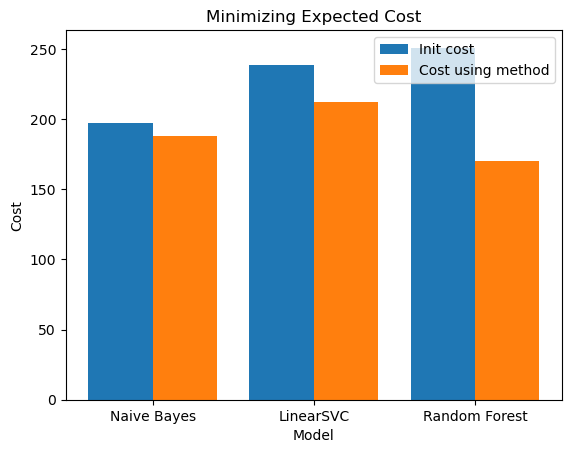

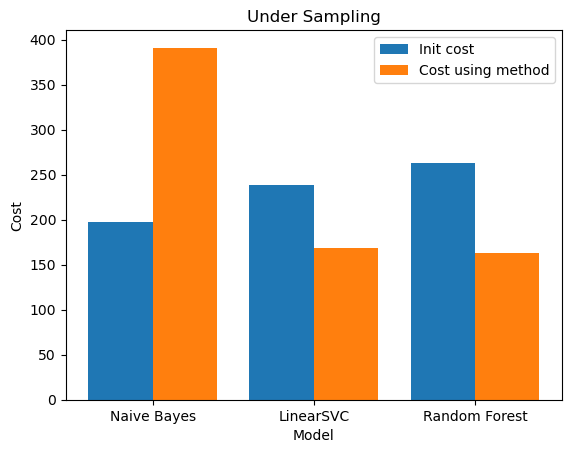

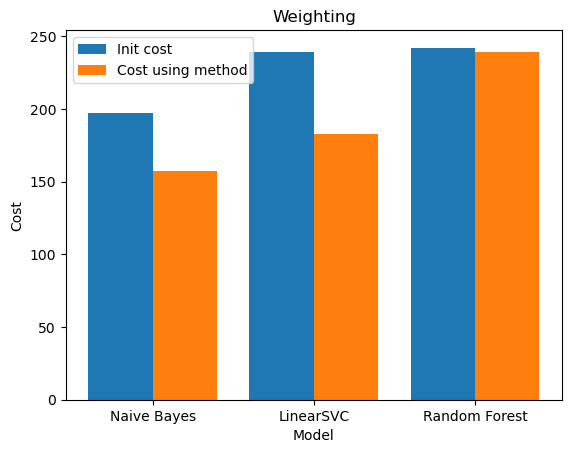

In [13]:
results = [isotonic_results, undersampling_results, results_weighting]
plot_each_method(methods,results,model_names)

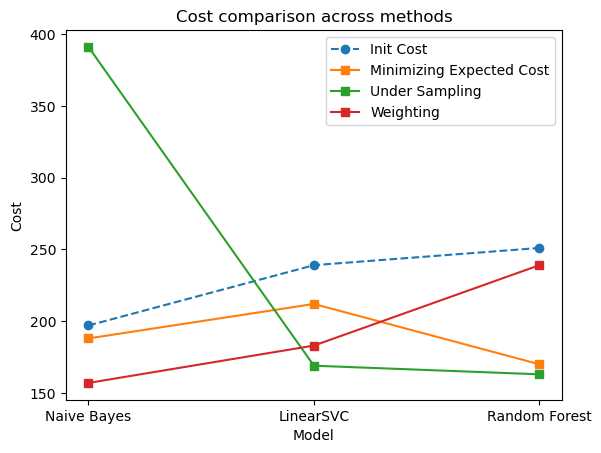

In [14]:
plot_across_methods(results,methods)

<h2>
<center>Report</center>
</h2>

<font size="3">
<div>
  <h3>Experiment Results Analysis</h3>
  <p>The aim of the experiment was to use three different cost-sensitive learning approaches (Minimizing the expected cost, Undersampling, Weighting) to fit three different machine learning algorithms (GaussianNB, LinearSVC, and RandomForestClassifier). The experiments were carried out by combining the different approaches with each of the algorithms, and the final cost was calculated for each experiment.</p>
  <h4>1. Minimizing the expected cost:</h4>
  <p>This approach shows improvements in the final cost for all three models. The most significant improvement is observed in the case of the Random Forest Classifier, with a reduction of 24.4% in the method cost. Linear SVC also shows a considerable improvement of 11.3% in the method cost, while GaussianNB has the least improvement of 4.6% in the method cost.</p>
  <h4>2. Undersampling:</h4>
  <p>This approach shows mixed results. While it improves the final cost of Linear SVC and RandomForestClassifier, it increases the final cost of GaussianNB. Linear SVC has the most significant improvement with a 29.3% reduction in the method cost, followed by RandomForestClassifier with a 34.4% reduction in the method cost. However, GaussianNB has a 98.5% increase in the method cost, making this approach unsuitable for this algorithm.</p>
  <h4>3. Weighting:</h4>
  <p>This approach shows improvements in the final cost for GaussianNB and Linear SVC but not for RandomForestClassifier. GaussianNB has the most significant improvement of 20.3% in the method cost, while Linear SVC has a modest improvement of 3.4% in the method cost. However, RandomForestClassifier shows a 17.9% increase in the method cost, making this approach unsuitable for this algorithm.</p>
  <h4>Overall:</h4>
  <p>The Minimizing the expected cost approach appears to be the most effective, as it improves the final cost for all three models. The Undersampling approach may be useful for Linear SVC and RandomForestClassifier, but it may not be suitable for GaussianNB. The Weighting approach shows mixed results, with improvements for some models and not for others.</p>
</div>
</font>